# Electricity Demand Forecasting
This notebook details some basic code to get a simple time series forecasting algorithm up and running. The focus here is not an optimised algorithm, but to create a simple base model from which we can explore the concepts of machine learning engineering in the rest of the book.

# Set Up

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit #Splitting for time series CV!

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('../data/AEP_hourly.csv')

In [3]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


<AxesSubplot:xlabel='Datetime'>

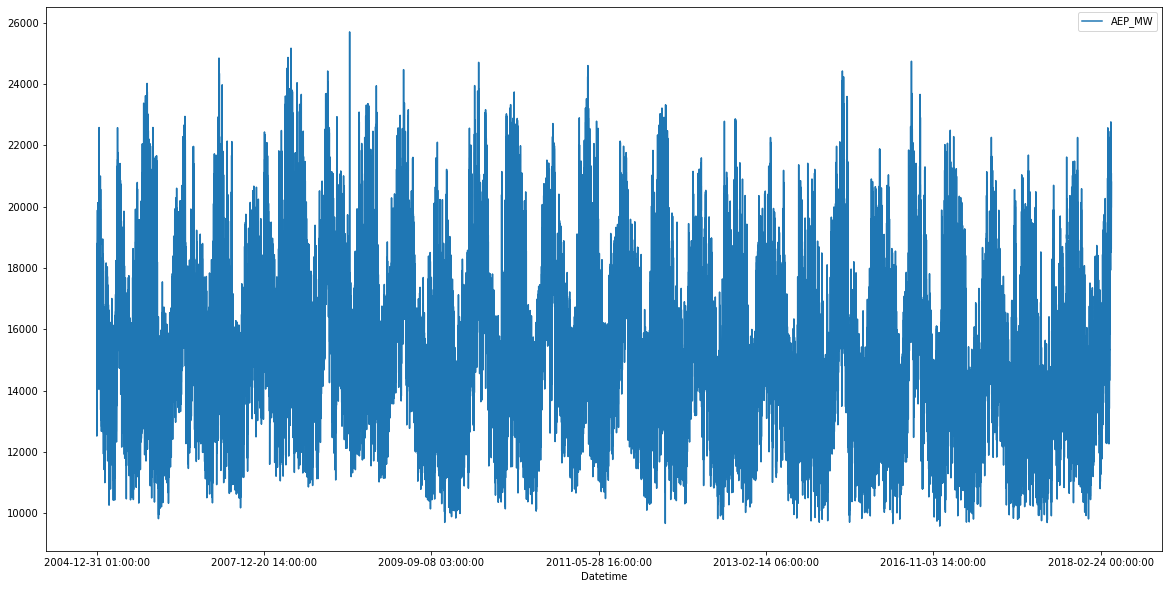

In [4]:
df.plot(x='Datetime', y='AEP_MW', figsize=(20,10))

## Prep for Prophet

In [5]:
df.rename(columns= {'Datetime': 'ds', 'AEP_MW': 'y'}, inplace=True)

In [6]:
df['ds']=df['ds'].astype('datetime64[ns]')

In [7]:
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [8]:
#Initialize Split Class, we'll split our data 5 times for cv
ts_splits = TimeSeriesSplit(n_splits=5)

# Train and Forecast

In [23]:
seasonality = {
    'yearly': True,
    'weekly': True,
    'daily': True
}
def time_split_train_test(df, time_series_splits, seasonality=seasonality):
    # for outputting
    df_results = pd.DataFrame()
    
    for i,(train_i,test_i) in enumerate(time_series_splits.split(df)):
        
        # grab split data
        df_train = df.copy().iloc[train_i,:]
        df_test = df.copy().iloc[test_i,:]
        
        # create Prophet model
        model=Prophet(
            yearly_seasonality=seasonality['yearly'],
            weekly_seasonality=seasonality['weekly'],
            daily_seasonality=seasonality['daily']
        )
        
        # train and predict
        model.fit(df_train)
        predicted = model.predict(df_test)

        # combine pred and training df's for plotting
        df_pred = predicted.loc[:,["ds","yhat"]]
        
        df_pred["y"] = df_test['y'].tolist()
        
        # Train or Test?
        df_train["train"]=True
        df_pred["train"]=False
        
        df_sub = df_train.append(df_pred).reset_index(drop=True)
        df_sub["split"]=i
        df_sub["rmse"]=(np.mean((df_sub.yhat-df_sub.y)**2))**.5 #calculating rmse for the split
        
        df_results = df_results.append(df_sub).reset_index(drop=True)
    return df_results

In [27]:
tmp = time_split_train_test(df.sort_values('ds', ascending=True).iloc[-1000:], ts_splits)

In [28]:
tmp.head()

,ds,y,train,yhat,split,rmse
0,2018-06-22 09:00:00,14978.0,True,NaN,0,1804.152254
1,2018-06-22 10:00:00,15557.0,True,NaN,0,1804.152254
2,2018-06-22 11:00:00,16087.0,True,NaN,0,1804.152254
3,2018-06-22 12:00:00,16544.0,True,NaN,0,1804.152254
4,2018-06-22 13:00:00,17081.0,True,NaN,0,1804.152254


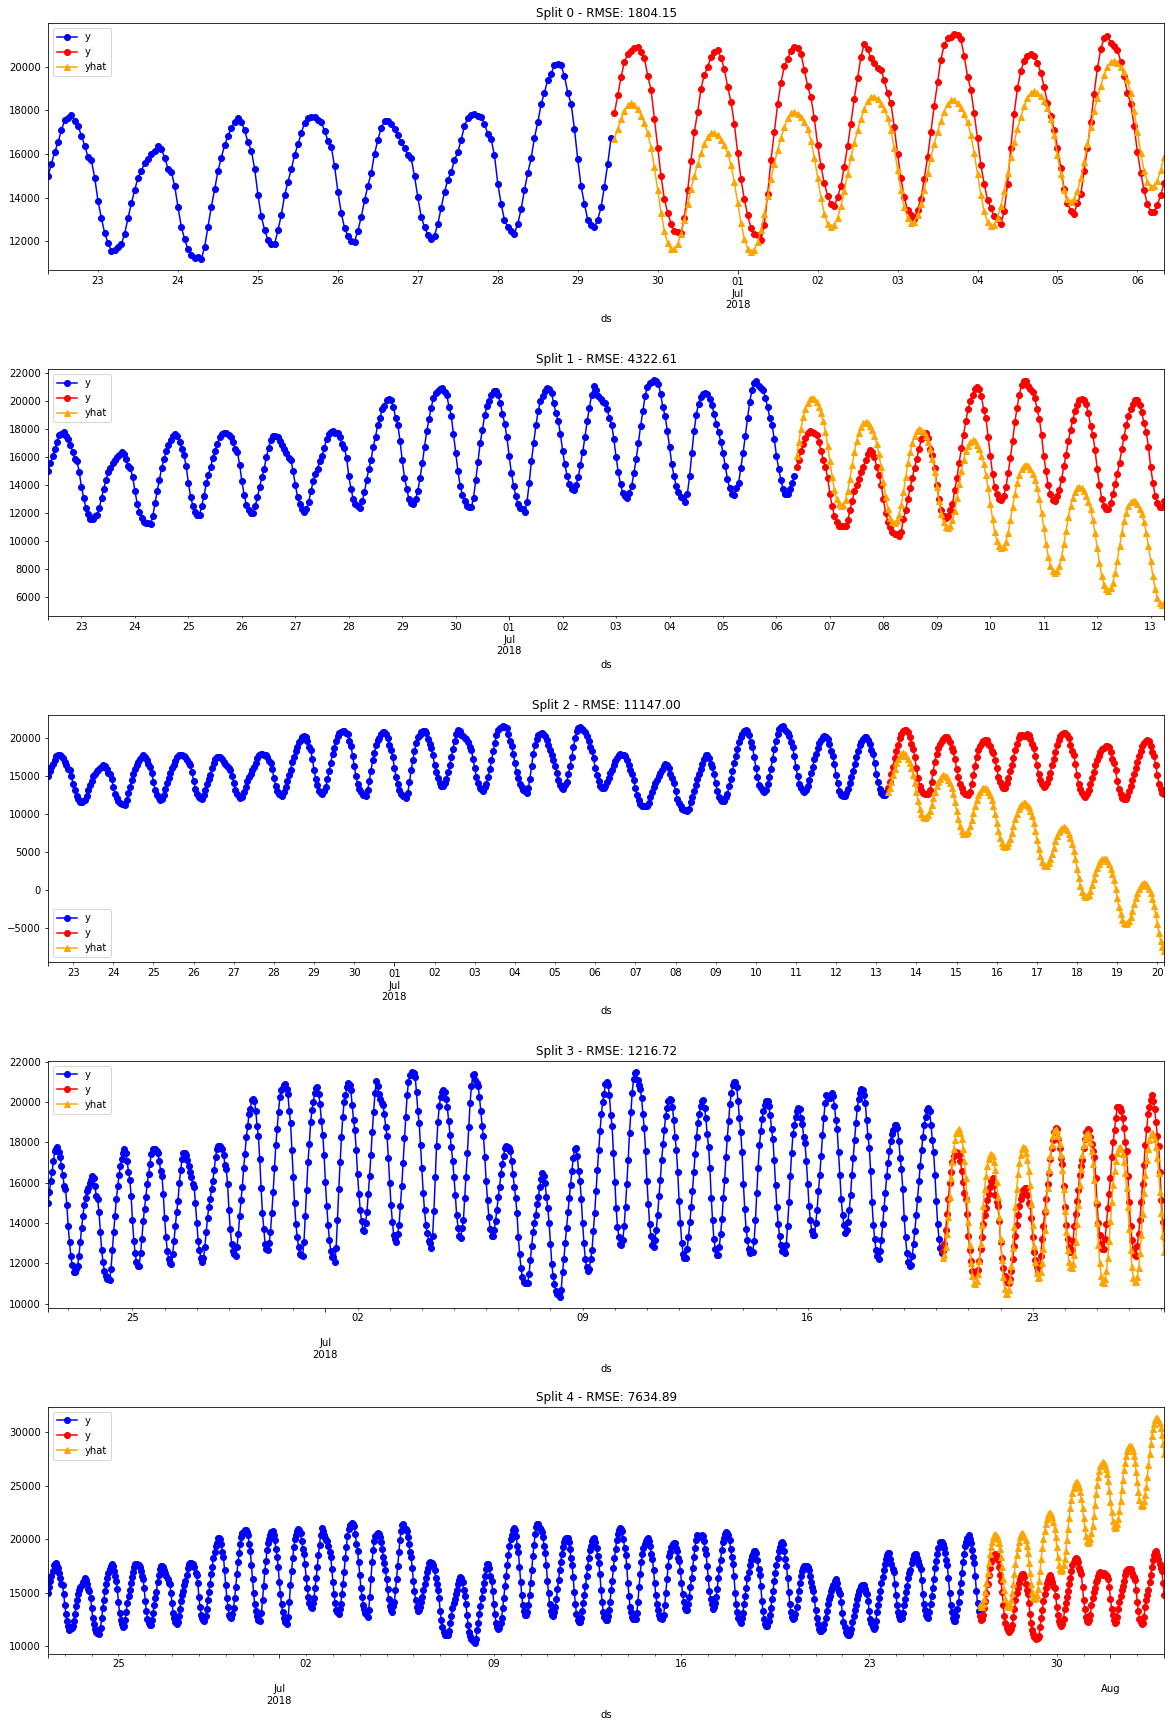

In [43]:
nrow = 5; ncol = 1;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20,30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, ax in enumerate(fig.axes):
    split_rmse = tmp[(tmp['split']==i) & (tmp['train']==False)]['rmse'].iloc[0]
    
    ax.set_title('Split '+str(i)+' - RMSE: '+"{:.2f}".format(split_rmse))
    
    tmp[(tmp['split']==i) & (tmp['train']==True)].plot(x='ds', y='y', ax=ax, color='blue', marker='o')
    tmp[(tmp['split']==i) & (tmp['train']==False)].plot(x='ds', y='y', ax=ax, color='red', marker='o')
    tmp[(tmp['split']==i) & (tmp['train']==False)].plot(x='ds', y='yhat', ax=ax, color='orange', marker='^')

In [58]:
# winner is split 3 - so what are the sizes we select? 
model_config = {'train_size': 668, 'forecast_horizon': 100}
                  
#tmp[(tmp['split']==3) & (tmp['train']==True)].shape[0]

#tmp[tmp['split']==3]['train'].groupby(tmp['train']).count().to_dict()

668

# Final Model Param and Training cycle

In [49]:

# def forecaster_train_and_export(df, seasonality):
#     # create Prophet model
#     model=Prophet(
#         yearly_seasonality=seasonality['yearly'],
#         weekly_seasonality=seasonality['weekly'],
#         daily_seasonality=seasonality['daily']
#     )
        
#     # train and predict
#     model.fit(df)
#     return model
    

train
False    166
True     668
Name: train, dtype: int64

NameError: name 'df_test' is not defined